# OSM Preprocessing

###Importing Libraries

In [7]:
#!pip install osmnx google-cloud-storage rasterio > /dev/null
#%pip install osmnx geopandas rasterio matplotlib shapely
#%pip install xarray rioxarray
#%pip install localtileserver

In [2]:
import os
import geopandas as gpd
import osmnx as ox
import rasterio
from rasterio.features import rasterize
import matplotlib.pyplot as plt
import numpy as np
#from google.colab import drive
import rasterio
import matplotlib.pyplot as plt
import ee
import geemap


#drive.mount('/content/drive')
#work_dir = '/content/drive/MyDrive/UHI-Detection-Analysis/data/raw/'
#os.makedirs(work_dir, exist_ok=True)


project_root = os.path.dirname(os.getcwd())
work_dir = os.path.join(project_root, 'data', 'raw')
os.makedirs(work_dir, exist_ok=True)

print(f"Working directory set to: {work_dir}")

Working directory set to: /Users/ozantuncbilek/Documents/Projects/UHI Detection and Analysis/urban-heat-island/data/raw


### Preprocessing

#### Area of Interest(Hamburg) Selection


In [5]:
place_name = "Hamburg, Germany"

# Tags to be used for OSM data (UHI Enhanced)
tags = {
    "building": True,
    "highway": True,
    "natural": ["water", "wetland"],
    "waterway": ["river", "canal", "stream"]
}

#PROCESSED_DIR = '/content/drive/MyDrive/UHI-Detection-Analysis/data/raw/osm/'
#os.makedirs(PROCESSED_DIR, exist_ok=True)

# Setup Directory Paths (Local Environment)
project_root = os.path.dirname(os.getcwd())
processed_dir = os.path.join(project_root, 'data', 'raw', 'osm')
os.makedirs(processed_dir, exist_ok=True)
print(f"OSM data will be saved to '{processed_dir}' directory.")

# Reference raster path (Sentinel-2 2024 Composite)

reference_raster_path = os.path.join(project_root, 'data', 'raw', 'sentinel_2', 'Hamburg_Composite_2024.tif')

if not os.path.exists(reference_raster_path):
    # Fallback check: sometimes filenames might be lowercase/uppercase depending on previous export
    alternative_path = os.path.join(project_root, 'data', 'raw', 'sentinel_2', 'hamburg_composite_2024.tif')
    if os.path.exists(alternative_path):
        reference_raster_path = alternative_path
        print(f"Reference raster found (case corrected): {reference_raster_path}")
    else:
        raise FileNotFoundError(f"Reference raster file not found: {reference_raster_path}")
else:
    print(f"Reference raster found: {reference_raster_path}")

OSM data will be saved to '/Users/ozantuncbilek/Documents/Projects/UHI Detection and Analysis/urban-heat-island/data/raw/osm' directory.
Reference raster found: /Users/ozantuncbilek/Documents/Projects/UHI Detection and Analysis/urban-heat-island/data/raw/sentinel_2/Hamburg_Composite_2024.tif


#### Read Reference Metadata
We read the metadata (resolution, CRS, transform) from the Sentinel-2 image downloaded in the previous step. This ensures that the generated OSM masks align perfectly with our satellite imagery pixel-for-pixel.

In [ ]:
# 1. Read Metadata from Reference Raster
# We use the 'reference_raster_path' defined in your previous cell
print(f"Reading reference metadata from: {reference_raster_path}")

with rasterio.open(reference_raster_path) as src:
    ref_meta = src.meta.copy()
    ref_shape = src.shape
    ref_transform = src.transform
    ref_crs = src.crs

# Update metadata for single-band binary masks
# We ensure the output will be a single channel (1) with unsigned integer format
ref_meta.update({
    "driver": "GTiff",
    "count": 1,
    "dtype": 'uint8',
    "nodata": 0
})

print(f"Reference CRS: {ref_crs}")
print(f"Reference Shape: {ref_shape}")

Reading reference metadata from: /Users/ozantuncbilek/Documents/Projects/UHI Detection and Analysis/urban-heat-island/data/raw/sentinel_2/Hamburg_Composite_2024.tif
Reference CRS: EPSG:4326
Reference Shape: (3344, 6681)


#### Define Processing Function
This function handles the core logic:
1.  **Download:** Fetches vector data from OpenStreetMap using `osmnx`.
2.  **Reproject:** Transforms coordinates to match the Sentinel-2 CRS.
3.  **Rasterize:** Converts vector geometries into a binary raster mask.

In [ ]:
# 2. Define Download and Rasterize Function (Returns Data Only)
def fetch_and_rasterize(place_name, tag, layer_name):
    print(f"\nProcessing layer: {layer_name}...")
    
    try:
        # Download vector data from OSM
        gdf = ox.features_from_place(place_name, tags=tag)
        
        # Filter geometry types (Polygons and Lines only)
        gdf = gdf[gdf.geometry.type.isin(['Polygon', 'MultiPolygon', 'LineString', 'MultiLineString'])]
        
        if gdf.empty:
            print(f"No features found for {layer_name}")
            return None

        # Reproject to match Sentinel-2 CRS
        # This aligns the vector data with the satellite image
        gdf = gdf.to_crs(ref_crs)

        # Rasterize
        # Burn geometries into a raster: 1 for feature, 0 for background
        mask = rasterize(
            shapes=((geom, 1) for geom in gdf.geometry),
            out_shape=ref_shape,
            transform=ref_transform,
            fill=0,
            dtype='uint8'
        )
        
        print(f"Successfully rasterized {layer_name}")
        return mask

    except Exception as e:
        print(f"Error processing {layer_name}: {e}")
        return None

#### Execute Processing
We iterate through the defined tags (buildings, highways, water, etc.) and generate the raster masks in memory.

In [9]:
# Dictionary to store the generated masks in memory
generated_masks = {}

# Iterate through the tags dictionary defined earlier
for key, value in tags.items():
    # Create a specific tag dictionary for the current layer
    # Example: {'building': True} or {'natural': ['water', 'wetland']}
    current_tag = {key: value}
    
    # Define a clean layer name (e.g., 'static_building')
    layer_name = f"static_{key}"
    
    # Run the function
    mask = fetch_and_rasterize(place_name, current_tag, layer_name)
    
    # Store the result if successful
    if mask is not None:
        generated_masks[layer_name] = mask

print(f"\nProcessing complete. Generated {len(generated_masks)} masks in memory.")


Processing layer: static_building...
Successfully rasterized static_building

Processing layer: static_highway...
Successfully rasterized static_highway

Processing layer: static_natural...
Successfully rasterized static_natural

Processing layer: static_waterway...
Successfully rasterized static_waterway

Processing complete. Generated 4 masks in memory.


#### Visualize Masks
Before saving to disk, we inspect the generated binary masks to ensure they correctly represent the urban features.

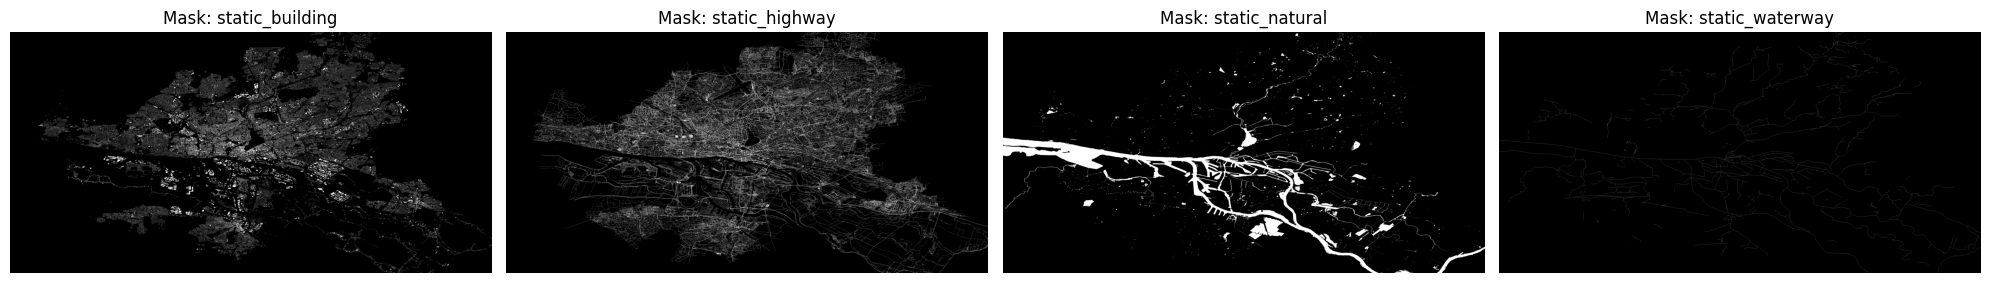

In [10]:
import matplotlib.pyplot as plt

# Check if we have data to plot
if generated_masks:
    # Create subplots based on the number of layers
    num_layers = len(generated_masks)
    fig, axes = plt.subplots(1, num_layers, figsize=(5 * num_layers, 5))
    
    # Handle the case of a single layer (axes is not a list)
    if num_layers == 1:
        axes = [axes]
    
    # Plot each mask
    for ax, (name, mask) in zip(axes, generated_masks.items()):
        ax.imshow(mask, cmap='gray') # Display as grayscale (0=black, 1=white)
        ax.set_title(f"Mask: {name}")
        ax.axis('off') # Hide axis ticks
        
    plt.tight_layout()
    plt.show()
else:
    print("No masks generated to visualize.")

#### Export to GeoTIFF

In [11]:
# Loop through the generated masks and save them
for name, mask in generated_masks.items():
    output_path = os.path.join(processed_dir, f"{name}.tif")
    
    try:
        with rasterio.open(output_path, 'w', **ref_meta) as dst:
            dst.write(mask, 1)
        print(f"Successfully exported: {output_path}")
        
    except Exception as e:
        print(f"Error saving {name}: {e}")

print("\nAll files exported successfully.")

Successfully exported: /Users/ozantuncbilek/Documents/Projects/UHI Detection and Analysis/urban-heat-island/data/raw/osm/static_building.tif
Successfully exported: /Users/ozantuncbilek/Documents/Projects/UHI Detection and Analysis/urban-heat-island/data/raw/osm/static_highway.tif
Successfully exported: /Users/ozantuncbilek/Documents/Projects/UHI Detection and Analysis/urban-heat-island/data/raw/osm/static_natural.tif
Successfully exported: /Users/ozantuncbilek/Documents/Projects/UHI Detection and Analysis/urban-heat-island/data/raw/osm/static_waterway.tif

All files exported successfully.


#### Generate Interactive HTML Map
We visualize the exported GeoTIFF masks on an interactive map to verify their spatial alignment with the real world. The map is saved as an HTML file in the `maps/` directory.

In [ ]:
import os
import folium
from localtileserver import get_folium_tile_layer, TileClient

# Define project paths
project_root = os.path.dirname(os.getcwd())
processed_dir = os.path.join(project_root, 'data', 'raw', 'osm')
maps_dir = os.path.join(project_root, 'maps')

# Ensure output directory exists
os.makedirs(maps_dir, exist_ok=True)

# Initialize Folium Map centered on Hamburg coordinates
m = folium.Map(location=[53.5511, 9.9937], zoom_start=12, tiles="CartoDB positron")

# Define layers and hex color codes for visualization
layer_config = {
    'static_building': '#ff0000', 
    'static_highway':  '#ffa500', 
    'static_natural':  '#0000ff', 
    'static_waterway': '#00ffff'  
}

print("Generating map using direct local file access...")

for name, color_hex in layer_config.items():
    tif_path = os.path.join(processed_dir, f"{name}.tif")
    
    if os.path.exists(tif_path):
        try:
            # Create a TileClient for the local GeoTIFF
            client = TileClient(tif_path)
            
            # Create a tile layer compatible with Folium
            # palette expects a hex code or matplotlib colormap name
            layer = get_folium_tile_layer(
                client, 
                palette=color_hex, 
                opacity=0.6, 
                name=name,
                attr='OSM Data'
            )
            
            # Add layer to the map
            layer.add_to(m)
            print(f"Successfully added layer: {name}")
            
        except Exception as e:
            print(f"Error adding {name}: {e}")
    else:
        print(f"File not found: {tif_path}")

# Add a layer control panel to toggle layers on/off
folium.LayerControl().add_to(m)

# Save the interactive map as HTML
html_output = os.path.join(maps_dir, "osm_masks_verification.html")
m.save(html_output)

print(f"\nMap saved to: {html_output}")

Generating map using direct local file access...
Successfully added layer: static_building
Successfully added layer: static_highway
Successfully added layer: static_natural
Successfully added layer: static_waterway

Map saved to: /Users/ozantuncbilek/Documents/Projects/UHI Detection and Analysis/urban-heat-island/maps/osm_masks_verification.html


### Summary and Next Steps

In this notebook, we successfully downloaded OpenStreetMap (OSM) vector data for Hamburg and rasterized it into **static feature masks** (specifically Buildings, Roads, and Water). These masks were generated using the most recent Sentinel-2 image as a spatial reference to ensure perfect pixel-to-pixel alignment (10m resolution, identical CRS).

The resulting GeoTIFF files were saved in the `data/raw/osm/` directory.

#### Methodological Note: Static vs. Historical Data
Currently, we are using **static OSM data** (fetched in the current year) to represent urban features for the entire analysis period (2014-2024).

To mitigate "time travel" discrepancies (e.g., new buildings in HafenCity appearing in the 2014 analysis but existing in the 2024 OSM map), we will incorporate **NDBI (Normalized Difference Built-up Index)** derived from satellite imagery as a **dynamic feature** in our deep learning model. This allows the model to "validate" the static OSM label against the actual physical material present at that time.

**Future Improvement (The "Historical" Way):**
If precise historical vector data becomes critical for model performance later, we can utilize the **OHSOME API** to fetch OSM snapshots for specific timestamps (e.g., `2015-06-01`) instead of the current snapshot.
*Ref: https://docs.ohsome.org/ohsome-api/v1/*

#### Next Steps:`03_data_processing.ipynb`
In the next notebook, we will create the final **Multi-Channel Tensor** for the U-Net model by fusing these datasets:
1.  **Static Layers:** OSM Buildings & Roads.
2.  **Dynamic Layers:** Land Surface Temperature (LST), NDVI (Vegetation), and NDBI (Built-up Index) derived from the yearly satellite data.

This data fusion approach will allow the model to detect Urban Heat Island (UHI) patterns with both structural context and temporal accuracy.